In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor


def split(df,label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te

def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype='bool')     
        chromosome[:int(0.3*n_feat)]=False             
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

def fitness_score(population):
    scores = []
    predictions_list = []
    for chromosome in population:
        model.fit(X_train.iloc[:,chromosome],Y_train)         
        predictions = model.predict(X_test.iloc[:,chromosome])
        predictions_list.append(predictions)
        scores.append(mean_absolute_error(Y_test,predictions))
    # print(len(scores), scores)
    scores, population, predictions_list = np.array(scores), np.array(population), np.array(predictions_list) 
    inds = np.argsort(scores)                                    
    return list(scores[inds]), list(population[inds,:]), list(predictions_list[inds,:]) 

def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen

def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        parent_1 , parent_2 = pop_nextgen[i] , pop_nextgen[i+1]
        # print(len(parent_1), len(parent_2), len(parent_1)//2)
        new_par = np.concatenate((parent_1[:len(parent_1)//2],parent_2[len(parent_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen

def mutation(pop_after_cross,mutation_rate,n_feat):   
    mutation_range = int(mutation_rate*n_feat) #86
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = [] 
        for i in range(0,mutation_range):
            pos = randint(0,n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]  
        pop_next_gen.append(chromo)
    return pop_next_gen

def generations(size,n_feat,n_parents,mutation_rate,n_gen):
    best_chromo= []
    best_score= []
    best_predictions = []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit, predictions_list = fitness_score(population_nextgen)
        print('Best score in generation',i+1,':',scores[0])  #2
        # print('len(population):', i+1, ':', len(pop_after_fit))
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
        best_predictions.append(predictions_list[0])
        # model.fit(X_train.iloc[:, pop_after_fit[0]],Y_train)         
        # predictionsjj = model.predict(X_test.iloc[:,pop_after_fit[0]])
        # print(mean_absolute_error(Y_test,predictionsjj), scores[0])
    return best_chromo,best_score, best_predictions

In [22]:
# pd.set_option("display.max_rows",1000000000)
# pd.set_option("display.max_columns",1000000000)
# np.set_printoptions(threshold=np.inf)
princess_data = pd.read_csv('C:/Users/robotic/Desktop/Luke/princess/disney_princess_popularity_dataset_300_rows.csv')
princess_data.drop(['Top3Hashtags'], axis=1, inplace=True)
princess_data = pd.get_dummies(princess_data)
princess_data.dropna(axis=0, inplace=True)
Y_full = princess_data["PopularityScore"]
X_full = princess_data
X_full.drop(['PopularityScore'],axis = 1,inplace = True)
X_train, X_test, Y_train, Y_test = split(X_full,Y_full)

print("Home dataset:\n", X_full.shape[0],"Records\n", X_full.shape[1],"Features")
# print(princess_data.shape[0], princess_data.shape[1])
# display(home_data)
# display(Y_full)

Home dataset:
 300 Records
 124 Features


In [19]:
model = XGBRegressor(n_estimators=1000, eta=0.01, max_depth=4, subsample=0.6, colsample_bytree=0.9)
model.fit(X_train, Y_train)
XGB_predictions = model.predict(X_test)
XGB_score = mean_absolute_error(Y_test, XGB_predictions)
print("XGB_score:", XGB_score)

rf_model = RandomForestRegressor(random_state=1, n_estimators=130)
rf_model.fit(X_train, Y_train)
RF_predictions = rf_model.predict(X_test)
RF_score = mean_absolute_error(Y_test, RF_predictions)
print("RF_score:", RF_score)

chromo_df_bc,score_bc, predictions_list = generations(size=80,n_feat=X_full.shape[1],n_parents=64,mutation_rate=0.20,n_gen=5)
G_best_index = score_bc.index(min(score_bc))
G_best_score, G_best_chromo, G_best_predictions = score_bc[G_best_index], chromo_df_bc[G_best_index], predictions_list[G_best_index]

print("XGB_GA_score:", G_best_score)

# model.fit(X_train.iloc[:,G_best_chromo], Y_train)        
# XGB_GA_predictions = model.predict(X_test.iloc[:,G_best_chromo])
# 

XGB_score: 14.67075159708659
RF_score: 13.740205128205131
Best score in generation 1 : 13.482842152913411
Best score in generation 2 : 13.218144785563151
Best score in generation 3 : 13.2765380859375
Best score in generation 4 : 13.06951156616211
Best score in generation 5 : 12.968248392740886
XGB_GA_score: 12.968248392740886


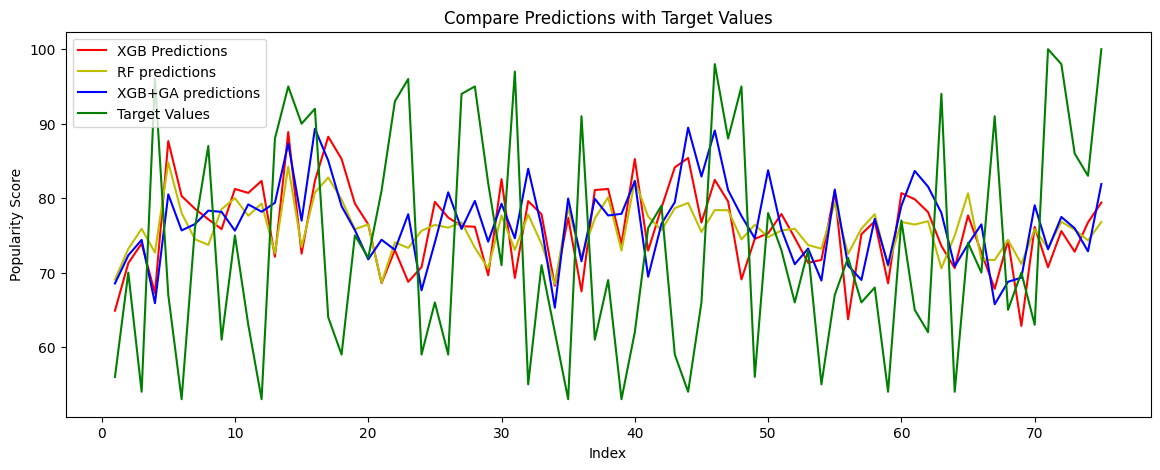

In [20]:
# print(mean_absolute_error(Y_test, G_best_predictions))
# model.fit(X_train.iloc[:,chromo_df_bc[1]], Y_train)        
# XGB_GA_predictions = model.predict(X_test.iloc[:,chromo_df_bc[1]])
# print(mean_absolute_error(Y_test, XGB_GA_predictions))

# print(len(G_best_predictions), len(XGB_predictions), len(RF_predictions), len(Y_test))

quantity = np.arange(1, len(G_best_predictions)+1)
fig = plt.figure(figsize=(14, 5))
plt.plot(quantity, XGB_predictions, 'r')
plt.plot(quantity, RF_predictions, 'y')
plt.plot(quantity, G_best_predictions, 'b')
plt.plot(quantity, Y_test, 'g')
plt.title('Compare Predictions with Target Values')
plt.xlabel('Index')
plt.ylabel('Popularity Score')
plt.legend(['XGB Predictions', 'RF predictions', 'XGB+GA predictions', 'Target Values'])
plt.show()

In [21]:
df = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'MSLE'])
df.loc[0] = ['XGBoost', XGB_score, mean_squared_error(Y_test, XGB_predictions), mean_squared_log_error(Y_test, XGB_predictions)]
df.loc[1] = ['Random Forests', RF_score, mean_squared_error(Y_test, RF_predictions), mean_squared_log_error(Y_test, RF_predictions)]
df.loc[2] = ['XGBoost+GA', G_best_score, mean_squared_error(Y_test, G_best_predictions), mean_squared_log_error(Y_test, G_best_predictions)]
display(df)

,Model,MAE,MSE,MSLE
0,XGBoost,14.670752,282.800980,0.051098
1,Random Forests,13.740205,247.340308,0.045217
2,XGBoost+GA,12.968248,242.093913,0.044683
